In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('Breast_cancer_dataset.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# data preprocessing steps

# changing diagnosis values - 0 for benign, 1 for malignant
df['diagnosis'] = df['diagnosis'].replace({'B': 0, 'M': 1})

# remove entries from the dataset with duplicate ids
df = df.drop_duplicates(subset='id')

# drop column 'Unnamed: 32' - likely stems from an error in how csvs are read
df = df.dropna(axis=1, how='all')

# check if any entries have missing values
# no entries should have missing vlaues but this double checks it
df = df.dropna()

# quickly check for any changes in the dataset
print(df.head())
num_rows, num_cols = df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

         id  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302          1        17.99         10.38          122.80     1001.0   
1    842517          1        20.57         17.77          132.90     1326.0   
2  84300903          1        19.69         21.25          130.00     1203.0   
3  84348301          1        11.42         20.38           77.58      386.1   
4  84358402          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  ar

/var/folders/w6/_7c7s1f13jncb6n7xbq780hc0000gn/T/ipykernel_4786/1117632144.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['diagnosis'] = df['diagnosis'].replace({'B': 0, 'M': 1})


From observing the outliers, there seems to be a pattern where large area_means and radius_means correlate with malignant diagnoses, and smaller values for those categories correlate with benign diagnoses. Additionally, the greater the number of outliers in an entry, the more likely it is to have a malignant diagnosis.

This is useful because it implies that there is some level of correlation between the larger the value is and the diagnosis, so removing the outliers may not be necessary.

In [4]:
# identifying outliers - starting with the mean values
mean_cols = (col for col in df.columns if col.endswith('_mean')) # gets columns in df that end with _mean
mean_df = df[mean_cols] # convert to dataframe

# print mean and standard deviation of each mean value
print("Mean values")
print(mean_df.mean())
print("\nStandard deviation values")
print(mean_df.std())

# compute z scores
z_scores = np.abs((mean_df - mean_df.mean()) / mean_df.std())
# get outliers where z_score for any one of the mean values is greater than 3
outliers_all = df[(z_scores > 3).any(axis=1)]
print(outliers_all)

# get outliers where z_score for at least 3 of the mean values is greater than 3
num_outlier_cols = (z_scores > 3).sum(axis=1)
outliers_3 = df[num_outlier_cols >= 3]
print(outliers_3) # all the entries here have a malignant diagnosis

Mean values
radius_mean                14.127292
texture_mean               19.289649
perimeter_mean             91.969033
area_mean                 654.889104
smoothness_mean             0.096360
compactness_mean            0.104341
concavity_mean              0.088799
concave points_mean         0.048919
symmetry_mean               0.181162
fractal_dimension_mean      0.062798
dtype: float64

Standard deviation values
radius_mean                 3.524049
texture_mean                4.301036
perimeter_mean             24.298981
area_mean                 351.914129
smoothness_mean             0.014064
compactness_mean            0.052813
concavity_mean              0.079720
concave points_mean         0.038803
symmetry_mean               0.027414
fractal_dimension_mean      0.007060
dtype: float64
            id  diagnosis  radius_mean  texture_mean  perimeter_mean  \
0       842302          1       17.990         10.38          122.80   
3     84348301          1       11.420         

Created a basic feature importance table below which involved creating a simple random forest regression model. The importance of features in determining the diagnosis is sorted in descending order.

In [5]:
# creating basic feature importance table
from sklearn.ensemble import RandomForestClassifier

x = df.drop(columns=['id', 'diagnosis'])
y = df['diagnosis']

model = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
model.fit(x, y)

importances = model.feature_importances_
feature_importances = pd.DataFrame({
    'feature': x.columns,
    'importance': importances
})

# Sort from most important to least
feature_importances = feature_importances.sort_values('importance', ascending=False)

print(feature_importances)

                    feature  importance
22          perimeter_worst    0.147590
23               area_worst    0.137287
27     concave points_worst    0.120906
7       concave points_mean    0.096243
20             radius_worst    0.071551
2            perimeter_mean    0.050775
6            concavity_mean    0.048627
0               radius_mean    0.047795
3                 area_mean    0.047010
26          concavity_worst    0.039822
13                  area_se    0.028399
21            texture_worst    0.016962
10                radius_se    0.016836
5          compactness_mean    0.015654
25        compactness_worst    0.014856
1              texture_mean    0.014405
24         smoothness_worst    0.013451
28           symmetry_worst    0.008514
12             perimeter_se    0.007886
4           smoothness_mean    0.007010
17        concave points_se    0.006700
29  fractal_dimension_worst    0.006588
16             concavity_se    0.005314
19     fractal_dimension_se    0.005232


Created a K-Nearest Neighbors Classifier to predict diagnosis.

Accuracy with k=1: 0.916083916083916
Accuracy with k=2: 0.9370629370629371
Accuracy with k=3: 0.9230769230769231
Accuracy with k=4: 0.9370629370629371
Accuracy with k=5: 0.9370629370629371
Accuracy with k=6: 0.951048951048951
Accuracy with k=7: 0.9440559440559441
Accuracy with k=8: 0.958041958041958
Accuracy with k=9: 0.958041958041958
Accuracy with k=10: 0.958041958041958
Accuracy with k=11: 0.958041958041958
Accuracy with k=12: 0.958041958041958
Accuracy with k=13: 0.958041958041958
Accuracy with k=14: 0.958041958041958
Accuracy with k=15: 0.958041958041958
Accuracy with k=16: 0.958041958041958
Accuracy with k=17: 0.958041958041958
Accuracy with k=18: 0.958041958041958
Accuracy with k=19: 0.958041958041958
Accuracy with k=20: 0.958041958041958
Accuracy with k=21: 0.951048951048951
Accuracy with k=22: 0.958041958041958
Accuracy with k=23: 0.951048951048951
Accuracy with k=24: 0.951048951048951
Accuracy with k=25: 0.958041958041958
Accuracy with k=26: 0.951048951048951
Accuracy with k=

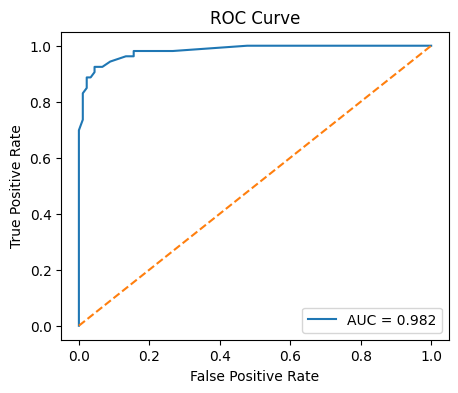

[1 0]
diagnosis
0    357
1    212
Name: count, dtype: int64


In [6]:
# KNN

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y = df['diagnosis']
Drop_columns = ['diagnosis', 'id']
X = df.drop(Drop_columns, axis = 1)

# Split data into Training and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=0)

# Model Training
scores = {}
for k in range(1, 32):
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train, y_train)

    # Evaluation
    y_pred = KNN.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    print(f"Accuracy with k={k}: {accuracy}")

    scores[k] = [accuracy, precision, recall, f1]

# Choose best model from hyperparameter tuning
best_k = max(scores, key=lambda k: scores[k][0]) # Select accuracy from all models
accuracy, precision, recall, f1 = scores[best_k]

print(f"Best k: {best_k}")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")


#ROC curve and AUC
proba = KNN.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, proba)
fpr, tpr, _ = roc_curve(y_test, proba)

print(f"AUC: {auc:.3f}")

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(loc="lower right")
plt.show()

print(df['diagnosis'].unique())
print(df['diagnosis'].value_counts())

Created a support vector machine model to predict diagnosis.


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

Accuracy: 0.9737
Precision: 1.0000
Recall: 0.9286
F1 Score: 0.9630
AUC: 0.995


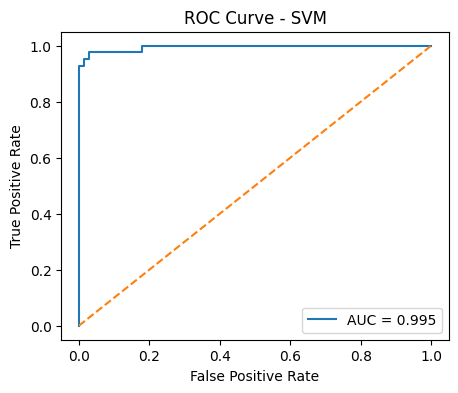

In [7]:
# support vector machine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# split data into features and target
X = df.drop(columns=['diagnosis', 'id'])
y = df['diagnosis']

# training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

#ROC curve and AUC
y_prob = svm_model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.3f}")


fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend(loc="lower right")
plt.show()


Based on the results, the SVM model performed extremely well, achieving an accuracy of 97%. The model had high precision and recall scores for both benign and malignant tumors, with an F1-score of 0.98 for benign and 0.96 for malignant case, demonstrating it is accuractly identifing true positives and true negatives. The model accurately identified all benign samples (recall 1.00), while the recall for malignant cases was 0.93, which means it missed 7% of malignant tumors so there is still a slight risk of false negatives.

In [8]:
# Random Forest Classifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Split data into features and target
X = df.drop(columns=['diagnosis', 'id'])
y = df['diagnosis']

# Split into training and testing sets (80/20 split, stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Random Forest classifier with 300 trees, max depth of 20
# random_state=42 ensures reproducibility
rf_model = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)

# Train the model on training data
rf_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test)

# Display detailed classification metrics
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred))

# Display individual performance metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# Display confusion matrix to see true positives, false positives, etc.
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

Accuracy: 0.9737
Precision: 1.0000
Recall: 0.9286
F1 Score: 0.9630

Confusion Matrix:
[[72  0]
 [ 3 39]]


In [10]:
# creating summary table to compare evaluation metrics of all models
from tabulate import tabulate
headers = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"]
data = [
    ["KNN", 0.958, 0.961, 0.925, 0.942],
    ["SVM", 0.974, 1.000, 0.923, 0.963],
    ["Random Forest", 0.974, 1.000, 0.923, 0.963]
]

print(tabulate(data, headers=headers, tablefmt="grid"))

+---------------+------------+-------------+----------+------------+
| Model         |   Accuracy |   Precision |   Recall |   F1 Score |
+===============+============+=============+==========+============+
| KNN           |      0.958 |       0.961 |    0.925 |      0.942 |
+---------------+------------+-------------+----------+------------+
| SVM           |      0.974 |       1     |    0.923 |      0.963 |
+---------------+------------+-------------+----------+------------+
| Random Forest |      0.974 |       1     |    0.923 |      0.963 |
+---------------+------------+-------------+----------+------------+
